# Question and Answer Application

## LLM model

In [1]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

## LangSmith Tracing

In [2]:
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langgraph_qna"

## Generate interview panel members

In [3]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Interviewer(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the interviewer.",
    )
    name: str = Field(
        description="Name of the interviewer."
    )
    role: str = Field(
        description="Role of the interviewer in the context of the topic.",
    )
    description: str = Field(
        description="Description of the interviewer focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    interviewers: List[Interviewer] = Field(
        description="Comprehensive list of interviewers with their roles and affiliations.",
    )

class GenerateInterviewersState(TypedDict):
    topic: str # Research topic
    max_interviewers: int # Number of interviewers
    human_interviewer_feedback: str # Human feedback
    interviewers: List[Interviewer] # Interviewer asking questions

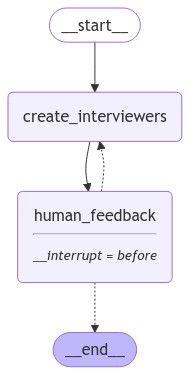

In [4]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

interviewer_instructions="""You are tasked with creating a set of AI interviewer personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the interviewers: 
        
{human_interviewer_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_interviewers} themes.

5. Assign one interviewer to each theme."""

def create_interviewers(state: GenerateInterviewersState):
    
    """ Create interviewers """
    
    topic=state['topic']
    max_interviewers=state['max_interviewers']
    human_interviewer_feedback=state.get('human_interviewer_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = interviewer_instructions.format(topic=topic,
                                                            human_interviewer_feedback=human_interviewer_feedback, 
                                                            max_interviewers=max_interviewers)

    # Generate question 
    interviewers = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of interviewers.")])
    
    # Write the list of analysis to state
    return {"interviewers": interviewers.interviewers}

def human_feedback(state: GenerateInterviewersState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateInterviewersState):
    """ Return the next node to execute """

    # Check if human feedback
    human_interviewer_feedback=state.get('human_interviewer_feedback', None)
    if human_interviewer_feedback:
        return "create_interviewers"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateInterviewersState)
builder.add_node("create_interviewers", create_interviewers)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_interviewers")
builder.add_edge("create_interviewers", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_interviewers", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [5]:
# Input
max_interviewers = 3 
topic = "LangGraph interview questions"
thread = {"configurable": {"thread_id": "dd001"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_interviewers":max_interviewers,}, thread, stream_mode="values"):
    # Review
    interviewers = event.get('interviewers', '')
    if interviewers:
        for interviewer in interviewers:
            print(f"Name: {interviewer.name}")
            print(f"Affiliation: {interviewer.affiliation}")
            print(f"Role: {interviewer.role}")
            print(f"Description: {interviewer.description}")
            print("-" * 50)

Name: Dr. Alice Chen
Affiliation: Tech Innovations Inc.
Role: AI Researcher
Description: Dr. Chen focuses on the intersection of AI and natural language processing, exploring how language models can be improved for better understanding and generation of human language.
--------------------------------------------------
Name: Prof. John Smith
Affiliation: University of Linguistics
Role: Linguist
Description: Prof. Smith specializes in the study of language structure and semantics, providing insights into how language models can be aligned with linguistic theories.
--------------------------------------------------
Name: Ms. Sarah Johnson
Affiliation: Data Ethics Council
Role: Ethics Analyst
Description: Ms. Johnson examines the ethical implications of AI technologies, particularly in language processing, and advocates for responsible AI development and deployment.
--------------------------------------------------


In [6]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [7]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_interviewer_feedback": 
                            "Remove duplicates"}, as_node="human_feedback")

{'configurable': {'thread_id': 'dd001',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef8cc99-63ef-6a41-8002-ec33893b01dd'}}

In [8]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    interviewers = event.get('interviewers', '')
    if interviewers:
        for interviewer in interviewers:
            print(f"Name: {interviewer.name}")
            print(f"Affiliation: {interviewer.affiliation}")
            print(f"Role: {interviewer.role}")
            print(f"Description: {interviewer.description}")
            print("-" * 50) 

Name: Dr. Alice Chen
Affiliation: Tech Innovations Inc.
Role: AI Researcher
Description: Dr. Chen focuses on the intersection of AI and natural language processing, exploring how language models can be improved for better understanding and generation of human language.
--------------------------------------------------
Name: Prof. John Smith
Affiliation: University of Linguistics
Role: Linguist
Description: Prof. Smith specializes in the study of language structure and semantics, providing insights into how language models can be aligned with linguistic theories.
--------------------------------------------------
Name: Ms. Sarah Johnson
Affiliation: Data Ethics Council
Role: Ethics Analyst
Description: Ms. Johnson examines the ethical implications of AI technologies, particularly in language processing, and advocates for responsible AI development and deployment.
--------------------------------------------------
Name: Dr. Emily Carter
Affiliation: Tech Innovations Inc.
Role: AI Resear

In [9]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_interviewer_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': 'dd001',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef8cc99-77f3-6f81-8004-a053b483fd76'}}

In [10]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [11]:
final_state = graph.get_state(thread)
interviewers = final_state.values.get('interviewers')

In [12]:
final_state.next

()

In [13]:
for interviewer in interviewers:
    print(f"Name: {interviewer.name}")
    print(f"Affiliation: {interviewer.affiliation}")
    print(f"Role: {interviewer.role}")
    print(f"Description: {interviewer.description}")
    print("-" * 100) 

Name: Dr. Emily Carter
Affiliation: Tech Innovations Inc.
Role: AI Researcher
Description: Dr. Carter focuses on the intersection of AI and natural language processing, exploring how LangGraph can enhance communication and understanding in AI systems.
----------------------------------------------------------------------------------------------------
Name: Mr. James Lee
Affiliation: Data Science Hub
Role: Data Analyst
Description: Mr. Lee specializes in data visualization and analytics, interested in how LangGraph can be utilized to interpret complex datasets and improve decision-making processes.
----------------------------------------------------------------------------------------------------
Name: Prof. Sarah Thompson
Affiliation: Educational Technology Group
Role: Educational Researcher
Description: Prof. Thompson investigates the applications of LangGraph in educational settings, aiming to enhance learning experiences through AI-driven tools.
------------------------------------

# Generate interview questions

In [14]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    interviewer: Interviewer # Interviewer asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [16]:
question_instructions = """You are an interviewer tasked with interviewing an expert to generate a list of questions and answers about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic, and then compose questions related to those insights.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    interviewer = state["interviewer"]
    messages = state["messages"]

    # Generate question 
    system_message = question_instructions.format(goals=interviewer.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    # Write messages to state
    return {"messages": [question]}

# Generate Questions and Answers

In [17]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

In [18]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

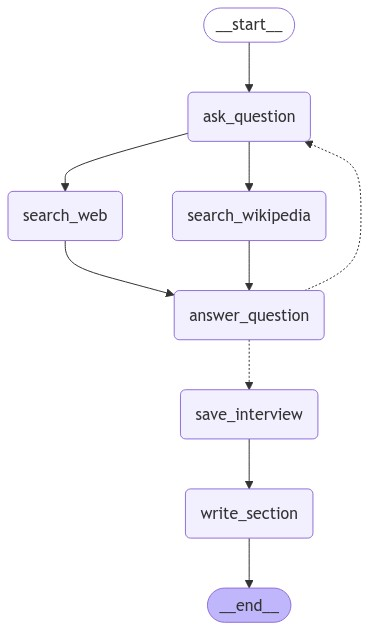

In [19]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an interviewer and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the interviewer.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

answer_instructions = """You are an expert being interviewed by an interviewer.

Here is the interviewer area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    interviewer = state["interviewer"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=interviewer.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a report containing interview questions and answers based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Questions and Answers (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the interviewer: 
{focus}

5. For the questions and answers section:
- Set up questions and answers with general background / context related to the focus area of the interviewer
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 200 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    interviewer = state["interviewer"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=interviewer.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [20]:
# Pick one analyst
interviewers[0]

Interviewer(affiliation='Tech Innovations Inc.', name='Dr. Emily Carter', role='AI Researcher', description='Dr. Carter focuses on the intersection of AI and natural language processing, exploring how LangGraph can enhance communication and understanding in AI systems.')

In [23]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were collecting technical questions and answers on {topic}?")]
thread = {"configurable": {"thread_id": "dd001"}}
interview = interview_graph.invoke({"interviewer": interviewers[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## Enhancing AI Communication: Insights from LangGraph

### Questions and Answers

1. **What is LangGraph and how does it function?**  
   LangGraph is a tool that models interactions as cyclical graphs, enabling the creation of complex workflows with multiple loops and conditional statements. This structure allows developers to orchestrate interactions among multiple Large Language Model (LLM) agents, ensuring efficient communication and task execution [1][3].

2. **What are the advantages of using LangGraph in AI applications?**  
   LangGraph extends the capabilities of the LangChain library, facilitating the development of stateful, multi-actor applications. Its cyclical graph representation allows for sophisticated state management and integration with external tools, enhancing the overall functionality of AI systems [2][4].

3. **What challenges does LangGraph present to developers?**  
   While LangGraph offers advanced features, it also comes with a higher entry barrier due to its complexity. Developers may need to invest time in understanding its graph-based approach to fully leverage its capabilities [1][3].

4. **How does LangGraph compare to other AI frameworks?**  
   Unlike other frameworks, LangGraph is fully integrated into the LangChain ecosystem, allowing users to benefit from its extensive integrations and observability features. This integration is crucial for building robust LLM workflows that require cycles [4][5].

### Sources
[1] https://towardsdatascience.com/from-basics-to-advanced-exploring-langgraph-e8c1cf4db787  
[2] https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141  
[3] https://blog.futuresmart.ai/langgraph-tutorial-for-beginners  
[4] https://blog.langchain.dev/langgraph-multi-agent-workflows/  
[5] https://en.wikipedia.org/wiki/Applications_of_artificial_intelligence  

# Final report

In [24]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_interviewers: int # Number of interviewers
    human_interviewer_feedback: str # Human feedback
    interviewers: List[Interviewer] # Interviewer asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

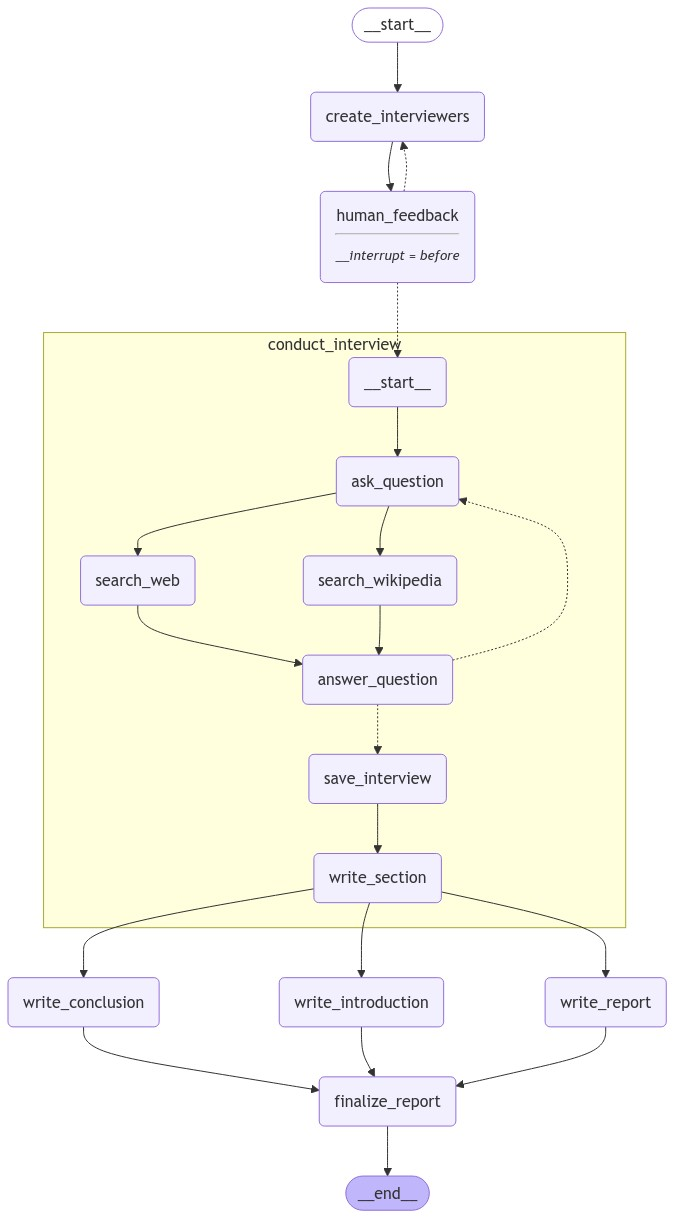

In [26]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_interviewer_feedback=state.get('human_interviewer_feedback')
    if human_interviewer_feedback:
        # Return to create_analysts
        return "create_interviewers"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"interviewer": interviewer,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were collecting technical questions and answers on {topic}?"
                                           )
                                                       ]}) for interviewer in state["interviewers"]]

report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of interviewers. Each interviewer has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their findings into questions and answers.

Your task: 

1. You will be given a collection of questions and answers from your interviewers.
2. Think carefully about the insights from each questions and answers.
3. Collect these questions and answers.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Questions and Answers
5. Do not mention any interviewer names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the questions and answers from your analysts to build your report from: 

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these questions and answers.")]) 
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Questions and Answers"):
        content = content.strip("## Questions and Answers")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_interviewers", create_interviewers)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_interviewers")
builder.add_edge("create_interviewers", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_interviewers", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [30]:
# Inputs
max_interviewers = 3 
topic = "LangGraph  overview"
thread = {"configurable": {"thread_id": "dd001"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_interviewers":max_interviewers}, 
                          thread, 
                          stream_mode="values"):
    
    interviewers = event.get('interviewers', '')
    if interviewers:
        for interviewer in interviewers:
            print(f"Name: {interviewer.name}")
            print(f"Affiliation: {interviewer.affiliation}")
            print(f"Role: {interviewer.role}")
            print(f"Description: {interviewer.description}")
            print("-" * 100)  

Name: Dr. Emily Chen
Affiliation: LangGraph Research Institute
Role: AI Researcher
Description: Dr. Chen focuses on the development of AI algorithms and their applications in natural language processing. She is particularly interested in how LangGraph can enhance language understanding and generation.
----------------------------------------------------------------------------------------------------
Name: Mr. David Patel
Affiliation: Tech Innovations Inc.
Role: Product Manager
Description: Mr. Patel oversees the integration of AI technologies into consumer products. He is keen on exploring how LangGraph can be utilized to improve user experience and engagement in tech applications.
----------------------------------------------------------------------------------------------------
Name: Prof. Sarah Johnson
Affiliation: University of Linguistics
Role: Linguist
Description: Prof. Johnson studies the intersection of language and technology. She aims to investigate the implications of Lan

In [31]:
# Confirm we are happy
graph.update_state(thread, {"human_interviewer_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': 'dd001',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef8cced-980e-6e5d-8002-8d6e6fc1868b'}}

In [32]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_introduction
--Node--
write_conclusion
--Node--
write_report
--Node--
finalize_report


In [33]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# Unlocking the Potential of LangGraph

## Introduction

LangGraph is revolutionizing the landscape of Large Language Models (LLMs) by providing a robust framework for building stateful, multi-actor applications. This report delves into the unique features of LangGraph, including its ability to create cyclical workflows that enhance agent adaptability and learning. We explore how LangGraph facilitates the development of efficient multi-agent workflows, bridging the gap between advanced AI capabilities and practical application development. Additionally, we examine its role in promoting linguistic diversity and supporting the creation of production-ready AI applications, ultimately enhancing user experiences across various tech domains.

---



1. **What is LangGraph and how does it differ from other LLM frameworks?**  
   LangGraph is a library designed for building stateful, multi-actor applications with Large Language Models (LLMs). Its core benefits include cycles, controllability, and persistence, which are essential for agentic architectures. Unlike other frameworks, LangGraph allows for the creation of cyclical graphs, enabling more complex interactions among multiple agents [1][2].

2. **How does LangGraph facilitate the development of multi-agent workflows?**  
   LangGraph simplifies the coordination and execution of multiple LLM agents by providing a structured framework. This allows developers to create workflows that can handle various tasks simultaneously, enhancing the overall efficiency of applications [3][4].

3. **What are the implications of using cycles in agent workflows?**  
   The ability to define flows that involve cycles is crucial for developing robust agent architectures. This feature allows agents to revisit previous states, making them more adaptable and capable of learning from past interactions, which is a significant advancement in AI applications [1][5].

4. **What is LangGraph and how does it relate to AI agents?**  
   LangGraph is a tool compatible with LangChain V2, specifically designed for developing advanced AI agents, particularly research agents. These agents can provide detailed, multi-step responses by referencing various data sources, enhancing the depth of user interactions and engagement in tech applications [1].

5. **How does LangGraph improve the development of production-ready AI applications?**  
   LangGraph offers a framework that bridges the gap between the capabilities of large language models (LLMs) and the practical requirements of real-world software development. This allows developers to create controlled, production-ready AI applications that can be integrated seamlessly into consumer products [2].

6. **What are the key benefits of using LangGraph in AI applications?**  
   By breaking tasks into smaller, manageable components, LangGraph facilitates easier debugging and flexibility in integrating tools and LLMs. This modular approach not only enhances the development process but also leads to more intelligent, context-aware AI systems that significantly improve user interactions [3].

7. **What is LangGraph and how does it contribute to linguistic diversity?**  
   LangGraph is a library designed for building stateful, multi-actor applications using Large Language Models (LLMs). It enhances the LangChain ecosystem by allowing the coordination of multiple chains, which can facilitate the development of applications that support various languages and dialects, thereby promoting linguistic diversity in digital spaces [1][2].

8. **What are the unique features of LangGraph that set it apart from other frameworks?**  
   LangGraph offers core benefits such as cycles, controllability, and persistence. These features enable developers to create complex workflows that can adapt and evolve, which is crucial for applications that aim to preserve and promote lesser-known languages in the digital age [1][3].

9. **How does LangGraph support the preservation of languages?**  
   By enabling the creation of conversational agents and multi-step applications, LangGraph can be utilized to develop tools that engage users in their native languages, thus fostering an environment where these languages can thrive and be documented [4][5].


---

## Conclusion

LangGraph emerges as a transformative tool in the realm of Large Language Models (LLMs), offering unique capabilities that enhance language understanding and user experience. By facilitating the development of stateful, multi-agent workflows, it allows for complex interactions and adaptability through cyclical processes. This modular approach not only streamlines the creation of production-ready AI applications but also promotes linguistic diversity by supporting various languages and dialects. As LangGraph continues to evolve, its potential to foster intelligent, context-aware systems positions it as a pivotal player in the future of AI technologies.

## Sources
[1] https://github.com/langchain-ai/langgraph  
[2] https://www.datacamp.com/tutorial/langgraph-tutorial  
[3] https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141  
[4] https://blog.langchain.dev/langgraph-multi-agent-workflows/  
[5] https://towardsdatascience.com/from-basics-to-advanced-exploring-langgraph-e8c1cf4db787  
[6] https://www.geeky-gadgets.com/using-langgraph-to-build-ai-agents/  
[7] https://opendatascience.com/langgraph-the-future-of-production-ready-ai-agents/  
[8] https://medium.com/cyberark-engineering/building-production-ready-ai-agents-with-langgraph-a-real-life-use-case-7bda34c7f4e4  
[9] https://pypi.org/project/langgraph/  
[10] https://medium.com/@gopiariv/langgraph-a-beginners-guide-to-building-ai-workflows-e500965f2ef9  
[11] https://github.com/langchain-ai/langgraph-exampl